In [24]:
import json
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
file = "./renttherunway_final_data.json"
df = pd.read_json(file,lines=True)
df = df[['user_id','item_id','rating']]
df = df.dropna()

In [26]:
nunique = dict(zip(df.columns, [df[col].nunique() for col in df.columns]))
summary = pd.DataFrame({'number_nan':df.isna().sum(), # [df.isna().sum()][0], here [0] coerces list into series with 12 separate values
                        'number_distinct':[df[col].nunique() for col in df.columns],
                       'distinct vals': [df[col].unique() for col in df.columns]})
summary

,number_nan,number_distinct,distinct vals
user_id,0,105508,"[420272, 273551, 360448, 909926, 151944, 73484..."
item_id,0,5850,"[2260466, 153475, 1063761, 126335, 616682, 364..."
rating,0,5,"[10.0, 8.0, 4.0, 6.0, 2.0]"


In [3]:
df.head()

,user_id,item_id,rating
0,420272,2260466,10.0
1,273551,153475,10.0
2,360448,1063761,10.0
3,909926,126335,8.0
4,151944,616682,10.0


In [4]:
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]
ratings = pd.DataFrame(np.zeros((n_users, n_items)), index = df.user_id.unique(), columns = list(df.item_id.unique()))
for row in df.itertuples():
    ratings.loc[row[1],row[2]] = row[3]
ratings = np.array(ratings)

In [5]:
print (str(n_users) + ' users')
print (str(n_items) + ' items')
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print ('Sparsity: {:4.2f}%'.format(sparsity))

105508 users
5850 items
Sparsity: 0.03%


In [6]:
max_count = 0
one_count = 0
two_count = 0
three_count = 0
for i in range(ratings.shape[0]):
    if len(ratings[i, :].nonzero()[0]) > 9:
        max_count+=1
        
    if len(ratings[i, :].nonzero()[0]) == 1:
        one_count += 1
        
    if len(ratings[i, :].nonzero()[0]) == 2:
        two_count += 1
        
    if len(ratings[i, :].nonzero()[0]) == 3:
        three_count += 1

In [7]:
print(one_count/n_users)
print(two_count/n_users)
print(three_count/n_users)
print(max_count)

0.6808014558137772
0.16936156499981045
0.06513250180081132
1388


In [6]:
test_users = []
for i in range(ratings.shape[0]):
    if len(ratings[i, :].nonzero()[0]) > 9:
        test_users.append(i)

In [7]:
def train_test_split(ratings, test_users, s):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in test_users:
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], size=s, replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test

In [8]:
train, test = train_test_split(ratings, test_users, 5)

In [9]:
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [10]:
class ExplicitMF():
    def __init__(self, 
                 ratings,
                 n_factors=40,
                 learning='sgd',
                 item_fact_reg=0.0, 
                 user_fact_reg=0.0,
                 item_bias_reg=0.0,
                 user_bias_reg=0.0,
                 verbose=False):
        """
        Train a matrix factorization model to predict empty 
        entries in a matrix. The terminology assumes a 
        ratings matrix which is ~ user x item
        
        Params
        ======
        ratings : (ndarray)
            User x Item matrix with corresponding ratings
        
        n_factors : (int)
            Number of latent factors to use in matrix 
            factorization model
        learning : (str)
            Method of optimization. Options include 
            'sgd' or 'als'.
        
        item_fact_reg : (float)
            Regularization term for item latent factors
        
        user_fact_reg : (float)
            Regularization term for user latent factors
            
        item_bias_reg : (float)
            Regularization term for item biases
        
        user_bias_reg : (float)
            Regularization term for user biases
        
        verbose : (bool)
            Whether or not to printout training progress
        """
        
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.n_factors = n_factors
        self.item_fact_reg = item_fact_reg
        self.user_fact_reg = user_fact_reg
        self.item_bias_reg = item_bias_reg
        self.user_bias_reg = user_bias_reg
        self.learning = learning
        if self.learning == 'sgd':
            self.sample_row, self.sample_col = self.ratings.nonzero()
            self.n_samples = len(self.sample_row)
        self._v = verbose

    def als_step(self,
                 latent_vectors,
                 fixed_vecs,
                 ratings,
                 _lambda,
                 type='user'):
        """
        One of the two ALS steps. Solve for the latent vectors
        specified by type.
        """
        if type == 'user':
            # Precompute
            YTY = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(YTY.shape[0]) * _lambda

            for u in range(latent_vectors.shape[0]):
                latent_vectors[u, :] = solve((YTY + lambdaI), 
                                             ratings[u, :].dot(fixed_vecs))
        elif type == 'item':
            # Precompute
            XTX = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(XTX.shape[0]) * _lambda
            
            for i in range(latent_vectors.shape[0]):
                latent_vectors[i, :] = solve((XTX + lambdaI), 
                                             ratings[:, i].T.dot(fixed_vecs))
        return latent_vectors

    def train(self, n_iter=10, learning_rate=0.1):
        """ Train model for n_iter iterations from scratch."""
        # initialize latent vectors        
        self.user_vecs = np.random.normal(scale=1./self.n_factors,size=(self.n_users, self.n_factors))
        self.item_vecs = np.random.normal(scale=1./self.n_factors,size=(self.n_items, self.n_factors))
        
        if self.learning == 'als':
            self.partial_train(n_iter)
        elif self.learning == 'sgd':
            self.learning_rate = learning_rate
            self.user_bias = np.zeros(self.n_users)
            self.item_bias = np.zeros(self.n_items)
            self.global_bias = np.mean(self.ratings[np.where(self.ratings != 0)])
            self.partial_train(n_iter)
    
    
    def partial_train(self, n_iter):
        """ 
        Train model for n_iter iterations. Can be 
        called multiple times for further training.
        """
        ctr = 1
        while ctr <= n_iter:
            if ctr % 10 == 0 and self._v:
                print ('\tcurrent iteration: {}'.format(ctr))
            if self.learning == 'als':
                self.user_vecs = self.als_step(self.user_vecs, 
                                               self.item_vecs, 
                                               self.ratings, 
                                               self.user_fact_reg, 
                                               type='user')
                self.item_vecs = self.als_step(self.item_vecs, 
                                               self.user_vecs, 
                                               self.ratings, 
                                               self.item_fact_reg, 
                                               type='item')
            elif self.learning == 'sgd':
                self.training_indices = np.arange(self.n_samples)
                np.random.shuffle(self.training_indices)
                self.sgd()
            ctr += 1

    def sgd(self):
        for idx in self.training_indices:
#             print('idx',idx)
            u = self.sample_row[idx]
#             print('u',u)
            i = self.sample_col[idx]
#             print('i',i)
            prediction = self.predict(u, i)
            e = self.ratings[u,i] - prediction # error 
#             print('prediction',prediction)
            
            # Update biases
            self.user_bias[u] += self.learning_rate * (e - self.user_bias_reg * self.user_bias[u])
#             print('self.user_bias[u]',self.user_bias[u])
            self.item_bias[i] += self.learning_rate * (e - self.item_bias_reg * self.item_bias[i])
#             print('self.item_bias[i]',self.item_bias[i])
            
            #Update latent factors
            self.user_vecs[u, :] += self.learning_rate * (e * self.item_vecs[i, :] - self.user_fact_reg * self.user_vecs[u,:])
            self.item_vecs[i, :] += self.learning_rate * (e * self.user_vecs[u, :] - self.item_fact_reg * self.item_vecs[i,:])
    
    def predict(self, u, i):
        """ Single user and item prediction."""
        if self.learning == 'als':
            return self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
        elif self.learning == 'sgd':
            prediction = self.global_bias + self.user_bias[u] + self.item_bias[i]
#             print('self.user_bias[u]_pre',self.user_bias[u])
#             print('self.item_bias[i]_pre',self.item_bias[i])
            prediction += self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
            return prediction
    
    def predict_all(self):
        """ Predict ratings for every user and item."""
        predictions = np.zeros((self.user_vecs.shape[0], 
                                self.item_vecs.shape[0]))
        r = self.user_vecs.shape[0]
        c = self.item_vecs.shape[0]
        global_bias = np.repeat(self.global_bias, r*c).reshape(r,c)
        user_bias = np.repeat(self.user_bias, c, axis=0).reshape(r,c)
#         print('user_bias:', item_bias)
        item_bias = np.repeat(self.item_bias, r, axis=0).reshape(c,r).T
#         print('item_bias:', item_bias)
        predictions = np.matmul(self.user_vecs,self.item_vecs.T)+global_bias+user_bias+item_bias
#         print('global_bias:', global_bias)
#         print('user_vecs:', self.user_vecs)
#         print('item_vecs:', self.item_vecs)
#         for u in range(self.user_vecs.shape[0]):
#             for i in range(self.item_vecs.shape[0]):
#                 predictions[u, i] = self.predict(u, i)
        return predictions
    
    def calculate_learning_curve(self, iter_array, test, learning_rate=0.1):
        """
        Keep track of MSE as a function of training iterations.
        
        Params
        ======
        iter_array : (list)
            List of numbers of iterations to train for each step of 
            the learning curve. e.g. [1, 5, 10, 20]
        test : (2D ndarray)
            Testing dataset (assumed to be user x item).
        
        The function creates two new class attributes:
        
        train_mse : (list)
            Training data MSE values for each value of iter_array
        test_mse : (list)
            Test data MSE values for each value of iter_array
        """
        iter_array.sort()
        self.train_mse =[]
        self.test_mse = []
        iter_diff = 0
        for (i, n_iter) in enumerate(iter_array):
            if self._v:
                print ('Iteration: {}'.format(n_iter))
            if i == 0:
                self.train(n_iter - iter_diff, learning_rate)
            else:
                self.partial_train(n_iter - iter_diff)

            predictions = self.predict_all()
#             print(predictions)

            self.train_mse += [get_mse(predictions, self.ratings)]
            self.test_mse += [get_mse(predictions, test)]
            if self._v:
                print ('Train mse: ' + str(self.train_mse[-1]))
                print ('Test mse: ' + str(self.test_mse[-1]))
            iter_diff = n_iter

In [28]:
# parameter tuning
iter_array = [100]
latent_factors = [40, 60, 80]
regularizations = [0.1, 0.5, 1.0, 1.5, 2.0]
regularizations.sort()

best_params = {}
best_params['n_factors'] = latent_factors[0]
best_params['reg'] = regularizations[0]
best_params['n_iter'] = 0
best_params['train_mse'] = np.inf
best_params['test_mse'] = np.inf
best_params['model'] = None

for fact in latent_factors:
    print ('Factors: {}'.format(fact))
    for reg in regularizations:
        print ('Regularization: {}'.format(reg))
        MF_SGD = ExplicitMF(train, n_factors=fact, learning='sgd',user_fact_reg=reg, 
                            item_fact_reg=reg,user_bias_reg=reg, item_bias_reg=reg)
        MF_SGD.calculate_learning_curve(iter_array, test, learning_rate=0.001)
        min_idx = np.argmin(MF_SGD.test_mse)
        if MF_SGD.test_mse[min_idx] < best_params['test_mse']:
            best_params['n_factors'] = fact
            best_params['reg'] = reg
            best_params['n_iter'] = iter_array[min_idx]
            best_params['train_mse'] = MF_SGD.train_mse[min_idx]
            best_params['test_mse'] = MF_SGD.test_mse[min_idx]
            best_params['model'] = MF_SGD
            print ('New optimal hyperparameters')
            print (pd.Series(best_params))

Factors: 40
Regularization: 0.1
New optimal hyperparameters
n_factors                                             40
reg                                                  0.1
n_iter                                               100
train_mse                                        1.51135
test_mse                                         2.09156
model        <__main__.ExplicitMF object at 0x110d00908>
dtype: object
Regularization: 0.5
Regularization: 1.0
Regularization: 1.5
Regularization: 2.0
Factors: 60
Regularization: 0.1
New optimal hyperparameters
n_factors                                             60
reg                                                  0.1
n_iter                                               100
train_mse                                        1.51756
test_mse                                         2.09151
model        <__main__.ExplicitMF object at 0x110d008d0>
dtype: object
Regularization: 0.5
Regularization: 1.0
Regularization: 1.5
Regularization: 2.0
Factors:

In [12]:
print('global bias:', MF_SGD.global_bias)
print('user bias:', MF_SGD.user_bias)
print('item bias:', MF_SGD.item_bias)
print('U:', MF_SGD.user_vecs)
print('V:', MF_SGD.item_vecs)

final_global_bias = MF_SGD.global_bias
final_user_bias = MF_SGD.user_bias
final_item_bias = MF_SGD.item_bias
U = MF_SGD.user_vecs
V = MF_SGD.item_vecs

global bias: 9.097053838430728
user bias: [-0.4740838   0.0808218   0.06636474 ... -0.07468627  0.09132585
  0.06199352]
item bias: [-0.41530413  0.02052327  0.18979074 ...  0.07048916 -0.45693873
 -0.09705462]
U: [[-0.01669967  0.01371345 -0.00332065 ... -0.01879132 -0.01040232
   0.01811771]
 [ 0.02625129  0.01410437 -0.0289035  ... -0.0142219   0.02050781
  -0.01260547]
 [-0.01080536 -0.01774298 -0.01236349 ... -0.00830043  0.01450926
  -0.00869612]
 ...
 [-0.00381015 -0.01492548 -0.01356817 ... -0.01687659 -0.01636669
  -0.00620276]
 [-0.00989788 -0.02685333 -0.01243646 ...  0.01930839 -0.01600906
  -0.0183856 ]
 [ 0.00912844 -0.00720642 -0.01639846 ... -0.01986111 -0.01658498
  -0.02155913]]
V: [[-1.14777925e-02 -1.48852925e-02 -2.07503680e-03 ... -2.41356098e-03
  -8.03334235e-03  9.62990135e-03]
 [-6.64665482e-04 -4.06237480e-03 -3.46778987e-03 ... -1.13462892e-03
   7.24690939e-04 -1.91493032e-03]
 [-4.96965145e-03 -2.94475168e-04  1.41369172e-03 ...  7.39721701e-04
   5.007012

In [30]:
U[0,:]

array([-0.01066704,  0.00226642,  0.01154316, -0.02941156, -0.00550189,
       -0.02877116, -0.01535801, -0.00745708,  0.02451411, -0.01053234,
        0.02014435, -0.00277532, -0.01382063,  0.01075337, -0.02523909,
       -0.0082922 , -0.01714394,  0.01763394, -0.00519305,  0.00679878,
        0.0282616 , -0.00094717,  0.00989916,  0.00635893, -0.0143815 ,
        0.01059468,  0.03970049,  0.00440436, -0.0021582 ,  0.00261869,
        0.01222807,  0.0003785 ,  0.0125584 , -0.04956333,  0.02693728,
       -0.02434111, -0.00878961, -0.01256701, -0.02119803,  0.01229174,
        0.00470316, -0.01490325, -0.0010371 ,  0.0173419 ,  0.02175083,
       -0.02095298, -0.01379473, -0.00296912, -0.00839032, -0.00353952,
       -0.01133045,  0.00639407,  0.02836075,  0.00572448,  0.00173862,
        0.00936048,  0.008445  , -0.01797048,  0.0079464 ,  0.01503095])

In [32]:
V[0,:]

array([-1.03014452e-02,  1.38210416e-04,  1.92508929e-02, -9.26118855e-03,
       -7.90539924e-03, -5.64277731e-03, -7.28721186e-03,  3.14477558e-03,
       -7.22314913e-03, -1.86437270e-02,  8.56162856e-03, -9.06633294e-03,
       -1.72638521e-02,  1.55243658e-02, -6.01848869e-03, -1.43398934e-03,
       -2.17713611e-02, -1.83626020e-03,  8.98409607e-03,  1.27789665e-03,
        7.46211684e-03,  3.72633214e-03,  2.68887707e-02,  3.79846471e-04,
       -1.10685808e-03,  2.60010832e-02,  8.95566501e-03,  1.70922659e-02,
        6.81661507e-03, -4.67698241e-05,  2.17580933e-02, -1.48293132e-02,
       -9.58099035e-03, -3.52790163e-02, -1.15493919e-02,  5.77906898e-03,
       -1.47655489e-02, -8.99469395e-03,  3.43069347e-04, -8.83979741e-03,
        2.00338634e-02,  8.13453013e-03, -1.56596072e-02,  1.46915033e-02,
        2.42215999e-02,  4.33249528e-03,  7.70659709e-03,  1.56071428e-02,
        1.36976239e-02, -3.06673930e-03,  2.33818791e-03,  1.65250804e-03,
        2.62632795e-02,  

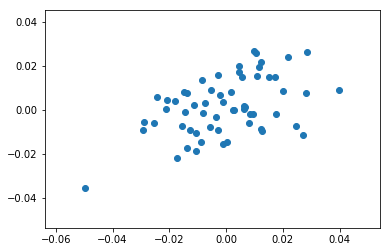

In [34]:
plt.scatter(U[0,:],V[0,:])

In [37]:
U[1,:]

array([ 6.78809494e-04, -2.35114164e-02,  8.08412162e-03,  1.79060476e-02,
       -2.54253227e-03,  7.41210823e-03, -2.37011770e-02, -6.09525513e-04,
       -1.57116987e-02,  2.53857456e-02, -2.09890418e-02, -1.71192956e-02,
       -4.28960621e-03,  1.95851019e-02, -2.20368847e-05,  1.72478380e-02,
        1.49058727e-02,  1.34147404e-02, -4.28429623e-05,  8.15106763e-03,
       -1.77261099e-02,  3.12406314e-03, -2.33166864e-03,  1.45367716e-02,
        1.43641419e-02,  2.33122815e-05,  9.80733888e-03,  4.82880280e-03,
       -1.04663727e-02,  5.51724951e-03,  1.42719852e-02, -8.14229472e-03,
       -2.96526948e-03,  1.19914486e-02, -2.91991900e-02,  1.18714433e-03,
       -1.23777734e-02, -1.72943458e-02, -1.08550327e-02, -1.49890323e-02,
        4.90114780e-03,  1.10718239e-02,  1.12140959e-02, -8.39570450e-03,
       -1.77699493e-02, -1.78697992e-03, -2.03321003e-02,  1.82558785e-02,
        9.88857154e-03, -9.61005814e-04, -2.93340549e-02, -3.32737625e-03,
       -1.38285393e-02, -

In [38]:
V[1,:]

array([ 2.58992925e-03,  2.49349867e-03,  3.66922841e-03, -1.66858317e-03,
        8.93352639e-04,  9.95694564e-04,  1.53434100e-03,  1.66949471e-03,
        1.45048540e-04, -2.32094014e-03,  4.50647552e-03,  2.40669172e-03,
        1.32269728e-03,  4.86720430e-03, -1.89891666e-04,  4.01635669e-03,
        2.33339330e-03, -1.01797860e-03, -7.85760717e-04, -2.16335815e-03,
       -1.29681253e-03,  3.14960536e-03, -3.25885340e-03,  2.71298312e-03,
        7.53970218e-04,  3.80064910e-03,  1.90055170e-03, -3.25193461e-03,
       -7.34662130e-04, -8.49655918e-04, -2.44690949e-04,  2.11242494e-03,
       -4.35108974e-04,  9.42073471e-04,  1.79463220e-03, -2.17377590e-03,
       -2.89180781e-04,  3.61387036e-05, -2.23810539e-03,  1.25607884e-03,
        1.25653067e-03, -1.09472268e-03, -3.07064727e-03,  2.13472097e-03,
       -8.23639442e-04, -1.21639430e-04, -1.86140410e-03,  9.35684640e-04,
        4.67082046e-03, -2.36435540e-03, -1.58877871e-03, -2.85009989e-03,
       -2.78969434e-03,  

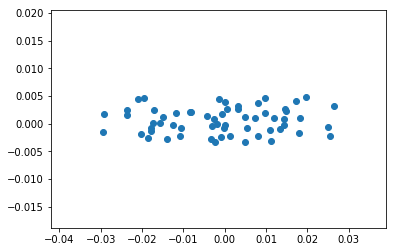

In [35]:
plt.scatter(U[1,:],V[1,:])

In [43]:
U[6,:]

array([-0.00250178, -0.00127511,  0.00030299,  0.00685947,  0.00050289,
        0.00249134, -0.00335444, -0.00166934,  0.00459093,  0.00651593,
        0.00371701, -0.00403769,  0.00391158, -0.00568827,  0.00440698,
       -0.00109381, -0.00344902, -0.00937664, -0.00311368, -0.00172666,
        0.00353591, -0.00823119,  0.00951479,  0.00060611,  0.00124075,
       -0.01001867,  0.00391665,  0.00703414,  0.00414115,  0.00100676,
       -0.00368593, -0.00538047,  0.00220783, -0.00268038, -0.00222366,
        0.01491714, -0.00028183, -0.0084798 ,  0.0057309 , -0.00430869,
       -0.00589247, -0.00637272,  0.0005162 , -0.0099144 ,  0.00456145,
        0.00059888, -0.00300578,  0.00501279, -0.00899886, -0.00281655,
       -0.00136308, -0.00215758,  0.00255146,  0.00019243, -0.00354117,
       -0.00263722,  0.00076019, -0.00957445, -0.00490442, -0.00439392])

In [44]:
V[6,:]

array([ 0.03389853,  0.01123524,  0.00190325,  0.01271124, -0.0011942 ,
       -0.00503939,  0.01950101,  0.01492299, -0.01149771, -0.00168359,
       -0.01935939, -0.01938038,  0.02816965,  0.00120263,  0.00196864,
       -0.00592165,  0.00580919, -0.01890179, -0.00027442,  0.00515944,
        0.00776526,  0.00031183,  0.00704298,  0.0127197 , -0.00212977,
        0.00184002,  0.02344588, -0.0019043 ,  0.01445933,  0.01087773,
       -0.02288171, -0.02473458, -0.0101205 ,  0.0092574 , -0.00690551,
        0.00451988, -0.0005332 , -0.01339856, -0.0104327 , -0.01973443,
       -0.00555878,  0.00194631,  0.00907221, -0.01402048, -0.00098338,
       -0.01703855,  0.01049701,  0.00440311, -0.01331697,  0.00500894,
       -0.00568917, -0.00233309,  0.01107254,  0.00281736, -0.00876446,
        0.01477694,  0.01589098,  0.00446138,  0.0094331 ,  0.00790803])

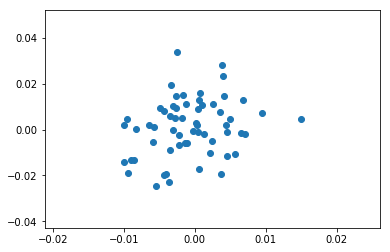

In [42]:
plt.scatter(U[6,:],V[6,:])

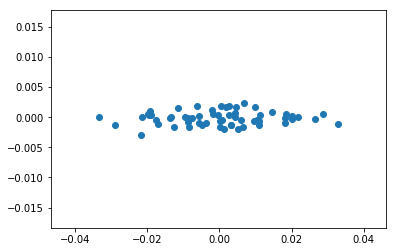

In [46]:
plt.scatter(U[3,:],V[3,:])

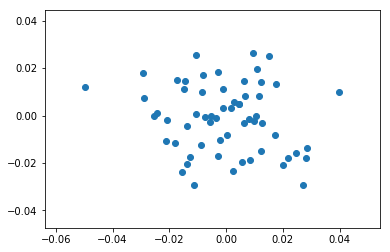

In [103]:
plt.scatter(U[0,:],U[1,:])

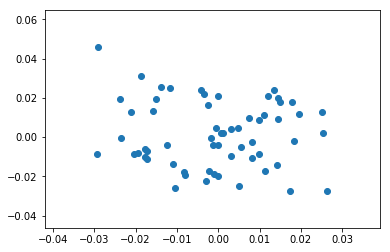

In [104]:
plt.scatter(U[1,:],U[2,:])

In [23]:
predictions = MF_SGD.predict_all()

In [52]:
predictions

array([[8.24919747, 8.65050368, 8.81627965, ..., 8.62837923, 8.16655579,
        8.52925245],
       [8.79482852, 9.20223758, 9.36786742, ..., 9.17769699, 8.72108255,
        9.08155055],
       [8.77660634, 9.18692172, 9.35299733, ..., 9.16519069, 8.70861189,
        9.06672725],
       ...,
       [8.63647158, 9.04531115, 9.21226063, ..., 9.02389285, 8.56759424,
        8.9254521 ],
       [8.80801968, 9.21113549, 9.37783124, ..., 9.18658133, 8.73042528,
        9.09183504],
       [8.77691644, 9.18261724, 9.34839987, ..., 9.15800332, 8.7018364 ,
        9.06494362]])

In [55]:
round_predictions = np.round(predictions)

In [58]:
test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [20]:
test_row, test_column = test.nonzero()

In [21]:
train_row, train_column = train.nonzero()

In [22]:
test[test_row,test_column]

array([ 6., 10.,  6., ..., 10., 10., 10.])

In [107]:
test_predictions=[]

for x in predictions[test_row,test_column]:
    if x<3:
        test_predictions.append(2)
    elif x<5:
        test_predictions.append(4)
    elif x<7:
        test_predictions.append(6)
    elif x<9:
        test_predictions.append(8)
    else:
        test_predictions.append(10)
        

In [109]:
accuracy_score(test[test_row,test_column],test_predictions)

0.5559077809798271

In [111]:
train_predictions=[]

for x in predictions[train_row,train_column]:
    if x<3:
        train_predictions.append(2)
    elif x<5:
        train_predictions.append(4)
    elif x<7:
        train_predictions.append(6)
    elif x<9:
        train_predictions.append(8)
    else:
        train_predictions.append(10)

In [112]:
accuracy_score(train[train_row,train_column],train_predictions)

0.6968174113938399

In [79]:
predictions[test_row,test_column]

array([9.19706792, 9.39285964, 8.90665427, ..., 9.31871005, 9.55741617,
       9.15215644])

In [78]:
pd.Series(test[test_row,test_column]).value_counts()

10.0    4260
8.0     1968
6.0      545
4.0      132
2.0       35
dtype: int64

In [75]:
predictions[test_row,test_column].min()

6.902044111748915

In [97]:
a = np.array([1.11,2,3.5,6,7.77,8,9.1])

In [98]:
a_classify = []
for x in a:
    if x<5:
        a_classify.append(0)
    else:
        a_classify.append(1)
        
    

1.11
2.0
3.5
6.0
7.77
8.0
9.1


In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def plot_learning_curve(iter_array, model):
    plt.plot(iter_array, model.train_mse, \
             label='Training', linewidth=3)
    plt.plot(iter_array, model.test_mse, \
             label='Test', linewidth=3)


    plt.xticks(fontsize=10);
    plt.yticks(fontsize=10);
    plt.xlabel('iterations', fontsize=15);
    plt.ylabel('MSE', fontsize=15);
    plt.legend(loc='best', fontsize=13);

In [118]:
MF_SGD = ExplicitMF(train, n_factors=50, learning='sgd', item_fact_reg=0.5, user_fact_reg=0.75, item_bias_reg=0.5,user_bias_reg=0.75,verbose=True)
iter_array = [100]
MF_SGD.calculate_learning_curve(iter_array, test, learning_rate=0.001)

Iteration: 1
Train mse: 2.001890879850438
Test mse: 2.3246028528533658
Iteration: 2
Train mse: 1.9819346575944172
Test mse: 2.3103212276732257
Iteration: 5
Train mse: 1.9407311848722433
Test mse: 2.276837918328355
Iteration: 10
Train mse: 1.8947121441280763
Test mse: 2.2384382521861728
Iteration: 25
	current iteration: 10
Train mse: 1.8041335363033257
Test mse: 2.1771027103423886
Iteration: 50
	current iteration: 10
	current iteration: 20
Train mse: 1.703376171955742
Test mse: 2.1376568634032176
Iteration: 100
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
Train mse: 1.5658616928550089
Test mse: 2.117359160111221
Iteration: 200
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
	current iteration: 60
	current iteration: 70
	current iteration: 80
	current iteration: 90
	current iteration: 100
Train mse: 1.392061569495246
Test mse: 2.1179082483561356


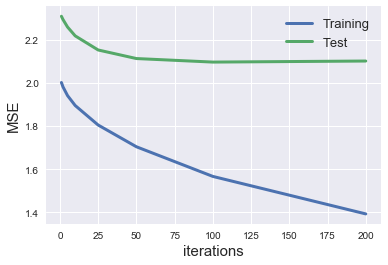

In [19]:
plot_learning_curve(iter_array, MF_SGD)

In [14]:
print('user bias:', abs(MF_SGD.user_bias).min(),abs(MF_SGD.user_bias).max())
print('item bias:', abs(MF_SGD.item_bias).min(),abs(MF_SGD.item_bias).max())

user bias: 4.192210847700495e-07 1.770740794686779
item bias: 0.0 1.5254147301339602
